In [1]:
import pandas as pd
import numpy as np
import glob, os

from seahorse import Graph, SContainer
from seahorse import constants
constants.SHOWMODE = True

cpal = ["#90ee90", "#6495ed", "#ca472f", "#f6c85f", "#6f4e7c", "#ffa056", "#558254", "#4ad9e1"]
cdef = "#9dbcd4"

cpalLib = cpal[:3]
cpalQual = [cpal[5], cpal[3], cpal[4]]

import matplotlib as mpl
mpl.rcParams['svg.fonttype'] = 'none' # Output SVG with text as text, not curves
mpl.rcParams['savefig.transparent'] = True # Save w/ transparent background by default

In [2]:
def save_replace_excel(fname, df, sheetname):
    with pd.ExcelWriter(fname, mode='a') as writer:  
        workBook = writer.book
        try:
            workBook.remove(workBook[sheetname])
        except:
            print("worksheet doesn't exist")
        finally:
            df.to_excel(writer, sheet_name=sheetname, index=False)
    
excelpath = '../../../nr-source-data.xlsx'
save_replace_excel_spmp = lambda df, sheetname: save_replace_excel(excelpath, df, sheetname)

In [3]:
fname = '../tables/kraken_self_single_results.tsv.gz'
df = pd.read_csv(fname, sep='\t', index_col=0, compression='gzip')
df.head()

,abundance,#covered,#assigned,rank,taxid,name,sample,assembly
0,69.03,22019962,22019962,U,0,unclassified,SPMP16,Short-read
1,30.97,9879798,0,R,1,root,SPMP16,Short-read
2,30.97,9879798,0,R1,131567,cellular organisms,SPMP16,Short-read
3,30.97,9879798,51138,D,2,Bacteria,SPMP16,Short-read
4,2.52,804242,804242,S,2819909,SPMP16_bin.13.fa,SPMP16,Short-read


In [4]:
fname = '../tables/mags_info_shortread.tsv'
short = pd.read_csv(fname, sep='\t', index_col=0)
short['assembly'] = 'Short-read'
short['name'] = short['name'] + '.fa'

fname = '../tables/mags_info_hybrid.tsv'
hybrid = pd.read_csv(fname, sep='\t', index_col=0)
hybrid['assembly'] = 'Hybrid'
hybrid['name'] = hybrid['name'] + '.fasta'

minfo = pd.concat((short, hybrid))
minfo.head()

,name,genus,species,Size,#_contigs,Contig_N50,Longest_contig,Completness,Contamination,CheckMStatus,RNAPass,MIMAG,SLCID,eigen_index,eigen_weight,SLCCat,assembly
0,SPMP01_bin.1.fa,Akkermansia,Akkermansia muciniphila,2233717.0,244.0,11568.0,46799.0,82.67,1.53,MEDIUM,False,MEDIUM,105.0,9.0,0.267135,Isolate,Short-read
1,SPMP01_bin.14.fa,Limosilactobacillus,Limosilactobacillus mucosae,1111771.0,139.0,9477.0,38475.0,63.79,0.00,MEDIUM,False,MEDIUM,17.0,2.0,0.497154,Isolate,Short-read
2,SPMP01_bin.15.fa,CAG-1427,CAG-1427 sp000436075,1339757.0,81.0,21875.0,101229.0,67.74,2.42,MEDIUM,False,MEDIUM,117.0,2.0,0.576977,Uncultivated,Short-read
3,SPMP01_bin.16.fa,RUG013,NaN,1266362.0,214.0,6701.0,40943.0,66.96,2.22,MEDIUM,False,MEDIUM,173.0,0.0,0.707107,Novel,Short-read
4,SPMP01_bin.17.fa,Enterococcus_B,Enterococcus_B faecium,2469094.0,243.0,13399.0,47973.0,91.84,3.45,HIGH,False,MEDIUM,339.0,0.0,NaN,Isolate,Short-read


In [5]:
df['name'] = df['name'].astype(str).str.strip()
df = df[df['rank'] == 'S']

minfo = minfo[['assembly', 'name', 'genus', 'species']]
df = df.merge(minfo, on=['assembly', 'name'], how='left')

df['genus_first'] = df["genus"].astype(str).apply(lambda name : name.split("_")[0])

df.head()

,abundance,#covered,#assigned,rank,taxid,name,sample,assembly,genus,species,genus_first
0,2.52,804242,804242,S,2819909,SPMP16_bin.13.fa,SPMP16,Short-read,Blautia_A,Blautia_A massiliensis,Blautia
1,2.02,645636,645636,S,2819889,SPMP16_bin.23.fa,SPMP16,Short-read,Agathobacter,Agathobacter faecis,Agathobacter
2,1.87,596612,596612,S,2819901,SPMP16_bin.28.fa,SPMP16,Short-read,Ruminococcus_C,Ruminococcus_C sp000980705,Ruminococcus
3,1.73,550516,550516,S,2819917,SPMP16_bin.64.fa,SPMP16,Short-read,CAG-279,CAG-279 sp000437795,CAG-279
4,1.49,474728,474728,S,2819913,SPMP16_bin.61.fa,SPMP16,Short-read,Gemmiger,Gemmiger formicilis,Gemmiger


## Supplemental figure 4

In [6]:
from scipy.stats import fisher_exact

sdf = df[~ df['genus'].isnull()]

sdf = sdf.groupby('assembly')['genus_first'].value_counts().rename("count").reset_index()
sdf = pd.pivot_table(sdf, index="genus_first", columns="assembly", values="count", fill_value=0)
sdf = sdf.reset_index()

sh, si = sdf[['Hybrid', 'Short-read']].sum().values

def apply_fe(row):
    a = np.array([
        [row['Hybrid'], row['Short-read']],
        [sh, si]
    ])
    
    odd, pvalue = fisher_exact(a, 'greater')
    return pd.Series({'odd': odd, 'pvalue': pvalue})

sdf = pd.concat((sdf, sdf.apply(apply_fe, axis=1)), axis=1)
sdf.head()

,genus_first,Hybrid,Short-read,odd,pvalue
0,51-20,1,1,0.620705,0.853331
1,AM51-8,5,2,1.551763,0.457602
2,Acetatifactor,33,17,1.204898,0.319981
3,Acidaminococcus,40,30,0.827607,0.817482
4,Acutalibacter,7,6,0.724156,0.808412


/home/jsgounot/anaconda3/envs/graphic/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  
/home/jsgounot/anaconda3/envs/graphic/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  if __name__ == '__main__':


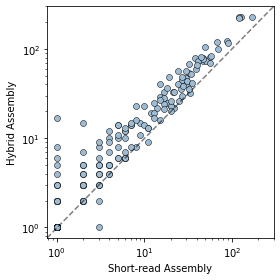

In [7]:
graph = Graph(sdf)
graph.shs.draw_diagonal(fmt='--', alpha=.5, color='black')
graph.sns.scatterplot(x='Short-read', y='Hybrid', color=cdef, edgecolor='black')

graph.ax.set_xscale('log')
graph.ax.set_xlim(0, 300)

graph.ax.set_yscale('log')
graph.ax.set_ylim(0, 300)

graph.ax.set_xlabel('Short-read Assembly')
graph.ax.set_ylabel('Hybrid Assembly')

graph.set_size_inches(4, 4)
graph.tight_layout()
graph.save('../img/sf4.pdf')

In [8]:
save_replace_excel_spmp(sdf, 'SFig 4')
sdf.head()

,genus_first,Hybrid,Short-read,odd,pvalue
0,51-20,1,1,0.620705,0.853331
1,AM51-8,5,2,1.551763,0.457602
2,Acetatifactor,33,17,1.204898,0.319981
3,Acidaminococcus,40,30,0.827607,0.817482
4,Acutalibacter,7,6,0.724156,0.808412


## Figure 1.B

In [9]:
sdf = df[~ df['genus'].isnull()]

sdf = sdf.groupby('assembly')['genus_first'].value_counts().rename("count").reset_index()
sdf = pd.pivot_table(sdf, index="genus_first", columns="assembly", values="count", fill_value=0)
sdf = sdf.reset_index()

sdf["HybridOnly"] = sdf["Hybrid"] - sdf["Short-read"]
sdf["PRC"]  = sdf["HybridOnly"] / sdf["Hybrid"]

sdf = sdf.sort_values("HybridOnly", ascending=False)

sdf.head()

assembly,genus_first,Hybrid,Short-read,HybridOnly,PRC
26,Blautia,229,122,107,0.467249
24,Bifidobacterium,231,127,104,0.450216
99,Faecalibacterium,220,122,98,0.445455
166,Ruminococcus,231,169,62,0.268398
84,Dorea,105,50,55,0.523810


In [10]:
# Sort by diff
top10 = sdf.sort_values('HybridOnly', ascending=False).head(10)[["genus_first", "Short-read", "HybridOnly"]]

# Next sort by total (should we do that?)
top10['Total'] = top10['HybridOnly'] + top10['Short-read']
top10 = top10.sort_values('Total', ascending=False)

order = list(top10["genus_first"])
top10 = pd.melt(top10, id_vars="genus_first", var_name="assembly", value_name="count")
top10["genus_first"] = pd.Categorical(top10["genus_first"], categories=order)
top10 = top10.sort_values("genus_first")

top10.head()

,genus_first,assembly,count
0,Bifidobacterium,Short-read,127
20,Bifidobacterium,Total,231
10,Bifidobacterium,HybridOnly,104
1,Ruminococcus,Short-read,169
21,Ruminococcus,Total,231


In [11]:
abu = df[~ df['genus'].isnull()]
abu = abu.groupby(["assembly", "sample", "genus_first", "species"])["abundance"].sum().reset_index()
abu = abu.pivot_table(index=["sample", "species", "genus_first"], columns="assembly", values="abundance", fill_value=0)
abu = abu.reset_index()

abu = abu[(abu["genus_first"].isin(order)) & (abu["Short-read"] == 0)]
abu["genus_first"] = pd.Categorical(abu["genus_first"], categories=order)
abu = abu.sort_values("genus_first")

abu

assembly,sample,species,genus_first,Hybrid,Short-read
3,SPMP01,Bifidobacterium longum,Bifidobacterium,11.67,0.0
1016,SPMP17,Bifidobacterium longum,Bifidobacterium,4.01,0.0
3650,SPMP79,Bifidobacterium longum,Bifidobacterium,9.21,0.0
1060,SPMP18,Bifidobacterium bifidum,Bifidobacterium,0.20,0.0
3610,SPMP78,Bifidobacterium adolescentis,Bifidobacterium,0.64,0.0
...,...,...,...,...,...
2141,SPMP41,Clostridium_Q sp003024715,Clostridium,0.46,0.0
320,SPMP08,Clostridium sp900540255,Clostridium,0.27,0.0
4246,SPMP94,Clostridium_Q sp003024715,Clostridium,0.36,0.0
3175,SPMP66,Clostridium sp001916075,Clostridium,0.24,0.0


/home/jsgounot/anaconda3/envs/graphic/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


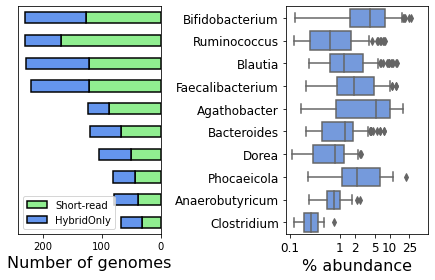

In [12]:
sc = SContainer(None, 1, 2)

# -------------------------
# Left panel

graph = sc.graph(0, top10)
graph.shs.stacked_barplot(x="genus_first", y="count", hue="assembly", stack_order=["Short-read", "HybridOnly"],
                         palette=cpal[:2], horizontal=True, edgecolor = "black", linewidth=1.5)

graph.ax.invert_xaxis()
graph.ax.set_ylabel("")
graph.ax.set_xlabel("Number of genomes", size=16)
graph.ax.legend(title='')
graph.remove_yticks()

# -------------------------
# Right panel

graph = sc.graph(1, abu)
graph.sns.boxplot(y="genus_first", x="Hybrid", color=cpal[1])

graph.ax.set_ylabel("")
graph.ax.set_xlabel("% abundance", size=16)
graph.apply_yticklabels(size=12)

graph.ax.set_xscale('log')
graph.ax.set_xlim(0, 60)

ticks = [0.1, 1, 2, 5, 10, 25]
graph.ax.set_xticks([], minor=True)
graph.ax.set_xticks(ticks)
graph.ax.set_xticklabels(ticks, size=12)

sc.set_size_inches(6, 4)
sc.tight_layout()
graph.save('../img/f1B.pdf')

In [13]:
save_replace_excel_spmp(top10, 'Fig 1.B left')
top10.head()

,genus_first,assembly,count
0,Bifidobacterium,Short-read,127
20,Bifidobacterium,Total,231
10,Bifidobacterium,HybridOnly,104
1,Ruminococcus,Short-read,169
21,Ruminococcus,Total,231


In [14]:
save_replace_excel_spmp(abu, 'Fig 1.B right')
abu.head()

assembly,sample,species,genus_first,Hybrid,Short-read
3,SPMP01,Bifidobacterium longum,Bifidobacterium,11.67,0.0
1016,SPMP17,Bifidobacterium longum,Bifidobacterium,4.01,0.0
3650,SPMP79,Bifidobacterium longum,Bifidobacterium,9.21,0.0
1060,SPMP18,Bifidobacterium bifidum,Bifidobacterium,0.20,0.0
3610,SPMP78,Bifidobacterium adolescentis,Bifidobacterium,0.64,0.0


## Figure 1.C

In [15]:
fname = '../tables/kraken_standard_all.parquet.tsv.gz'
standard = pd.read_parquet(fname)

standard = standard[standard['rank'] == 'S']
standard['genus'] = standard['name'].apply(lambda value: value.split()[0])
standard.head()

,abundance,#covered,#assigned,rank,taxid,name,sample,genus
11,2.59,1174791,1174791,S,2479767,Blautia sp. SC05B48,SPMP71,Blautia
12,0.04,17387,17387,S,2779518,Blautia sp. LZLJ-3,SPMP71,Blautia
13,0.00,160,160,S,1796616,Blautia sp. YL58,SPMP71,Blautia
14,0.12,53077,53077,S,33035,Blautia producta,SPMP71,Blautia
15,0.11,51604,0,S,1322,Blautia hansenii,SPMP71,Blautia


In [16]:
bifido_species_anno = set(df[df['genus'] == 'Bifidobacterium']['species'].unique())
bifido_species_standard = set(standard[standard['genus'] == 'Bifidobacterium']['name'].unique())

bifido_common = bifido_species_anno & bifido_species_standard
bifido_common

{'Bifidobacterium adolescentis',
 'Bifidobacterium animalis',
 'Bifidobacterium bifidum',
 'Bifidobacterium breve',
 'Bifidobacterium catenulatum',
 'Bifidobacterium dentium',
 'Bifidobacterium longum',
 'Bifidobacterium pseudocatenulatum'}

In [17]:
sdf = df[df['species'].isin(bifido_common)]
sdf = sdf.groupby(["assembly", "sample", "genus", "species"])["abundance"].sum()
sdf = sdf.rename("abundance").reset_index()
sdf = pd.pivot_table(sdf, index=["sample", "species", "genus"], columns="assembly", values="abundance", fill_value=0)
sdf = sdf.reset_index()

standard_bifido = standard[standard['name'].isin(bifido_common)]
standard_bifido = standard_bifido[['sample', 'name', 'abundance']]
standard_bifido.columns = ['sample', 'species', 'Standard']

sdf = sdf.merge(standard_bifido, on=['sample', 'species'], how='left')
sdf.head()

,sample,species,genus,Hybrid,Short-read,Standard
0,SPMP01,Bifidobacterium longum,Bifidobacterium,11.67,0.00,9.16
1,SPMP02,Bifidobacterium dentium,Bifidobacterium,0.00,4.87,0.39
2,SPMP02,Bifidobacterium longum,Bifidobacterium,8.46,0.00,6.04
3,SPMP04,Bifidobacterium adolescentis,Bifidobacterium,3.30,0.00,3.18
4,SPMP04,Bifidobacterium longum,Bifidobacterium,0.95,1.25,0.92


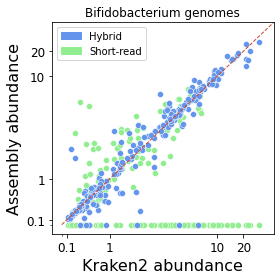

In [18]:
from seahorse import basic_legend

graph = Graph(sdf)
graph.ax.plot([0, 45], [0, 45], linestyle="--", linewidth=1, color="#ca472f") 

graph.sns.scatterplot(x="Standard", y="Short-read", color=cpal[0])
graph.sns.scatterplot(x="Standard", y="Hybrid", color=cpal[1])

basic_legend(graph.ax, {'Hybrid': cpal[1], 'Short-read': cpal[0]})

graph.ax.set_yscale("symlog")
graph.ax.set_xscale("symlog")  

graph.ax.set_ylim((-.2, 45))
graph.ax.set_xlim((-.2, 45))

graph.ax.set_xlabel("Kraken2 abundance", size=16)
graph.ax.set_ylabel("Assembly abundance", size=16)

ticks = [0.1, 1, 10, 20]
graph.ax.set_xticks(ticks)
graph.ax.set_xticklabels(ticks, size=12)
graph.ax.set_yticks(ticks)
graph.ax.set_yticklabels(ticks, size=12)

graph.ax.set_title("Bifidobacterium genomes")
graph.set_size_inches(4, 4)
graph.tight_layout()
graph.save('../img/f1C.pdf')

In [19]:
save_replace_excel_spmp(sdf, 'Fig 1.C')
sdf.head()

,sample,species,genus,Hybrid,Short-read,Standard
0,SPMP01,Bifidobacterium longum,Bifidobacterium,11.67,0.00,9.16
1,SPMP02,Bifidobacterium dentium,Bifidobacterium,0.00,4.87,0.39
2,SPMP02,Bifidobacterium longum,Bifidobacterium,8.46,0.00,6.04
3,SPMP04,Bifidobacterium adolescentis,Bifidobacterium,3.30,0.00,3.18
4,SPMP04,Bifidobacterium longum,Bifidobacterium,0.95,1.25,0.92


## Supplementary figure 3

In [20]:
sdf = df[df['species'].isin(bifido_common)]
sdf = sdf.groupby(["assembly", "sample", "genus", "species"])["abundance"].sum()
sdf = sdf.rename("abundance").reset_index()
sdf = pd.pivot_table(sdf, index=["sample", "species", "genus"], columns="assembly", values="abundance", fill_value=0)
sdf = sdf.reset_index()

standard_bifido = standard[standard['name'].isin(bifido_common)]
standard_bifido = standard_bifido[['sample', 'name', 'abundance']]
standard_bifido.columns = ['sample', 'species', 'Standard']

sdf = sdf.merge(standard_bifido, on=['sample', 'species'], how='outer').drop('genus', axis=1).fillna(0)
sdf.head()

,sample,species,Hybrid,Short-read,Standard
0,SPMP01,Bifidobacterium longum,11.67,0.00,9.16
1,SPMP02,Bifidobacterium dentium,0.00,4.87,0.39
2,SPMP02,Bifidobacterium longum,8.46,0.00,6.04
3,SPMP04,Bifidobacterium adolescentis,3.30,0.00,3.18
4,SPMP04,Bifidobacterium longum,0.95,1.25,0.92


In [21]:
# https://en.wikipedia.org/wiki/Approximation_error

ssdf = sdf.groupby('sample')[['Hybrid', 'Short-read', 'Standard']].sum().reset_index()
ssdf['diff_sr'] = (ssdf['Standard'] - ssdf['Short-read']).abs()
ssdf['diff_hy'] = (ssdf['Standard'] - ssdf['Hybrid']).abs()

ssdf['re_sr'] = ((ssdf['Standard'] - ssdf['Short-read']).abs() / ssdf['Standard']) * 100
ssdf['re_hy'] = ((ssdf['Standard'] - ssdf['Hybrid']).abs() / ssdf['Standard']) * 100

ssdf.describe().round(2)

,Hybrid,Short-read,Standard,diff_sr,diff_hy,re_sr,re_hy
count,109.00,109.00,109.00,109.00,109.00,109.00,109.00
mean,7.31,2.10,10.54,8.45,3.43,65.80,25.34
std,7.80,2.31,10.30,9.62,6.83,30.70,30.60
min,0.00,0.00,0.01,0.00,0.01,0.00,0.13
25%,1.37,0.44,2.22,0.94,0.12,46.33,3.49
50%,5.51,1.36,7.77,5.11,0.50,73.43,8.43
75%,9.75,3.25,15.17,12.94,2.42,90.75,36.54
max,38.13,9.69,41.79,41.79,40.66,100.00,100.00


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Short-read vs. Hybrid: Wilcoxon test (paired samples), P_val:8.705e-16 Stat=2.330e+02


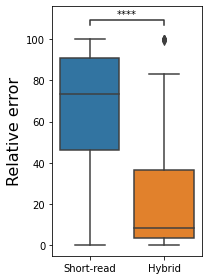

In [22]:
abu = ssdf.melt(id_vars='sample', value_vars=['re_sr', 're_hy'], var_name='assembly', value_name='relative_error')
abu['assembly'] = abu['assembly'].map({'re_sr': 'Short-read', 're_hy': 'Hybrid'})

graph = Graph(abu)
graph.sns.boxplot(x='assembly', y='relative_error')

graph.ax.set_xlabel('')
graph.ax.set_ylabel('Relative error', size=16)

graph.make_annot(x='assembly', y='relative_error', test='Wilcoxon')

graph.set_size_inches(3, 4)
graph.tight_layout()
graph.save('../img/sf3.svg')

In [23]:
# Check it's doing what we want
from scipy.stats import wilcoxon
wilcoxon(ssdf['re_sr'], ssdf['re_hy'])

WilcoxonResult(statistic=233.0, pvalue=8.705433675211284e-16)

In [24]:
save_replace_excel_spmp(ssdf, 'SFig 3')
ssdf.head()

,sample,Hybrid,Short-read,Standard,diff_sr,diff_hy,re_sr,re_hy
0,SPMP01,11.67,0.00,35.96,35.96,24.29,100.000000,67.547275
1,SPMP02,8.46,4.87,28.22,23.35,19.76,82.742736,70.021262
2,SPMP03,0.00,0.00,0.04,0.04,0.04,100.000000,100.000000
3,SPMP04,4.25,1.25,4.29,3.04,0.04,70.862471,0.932401
4,SPMP05,1.89,0.96,2.22,1.26,0.33,56.756757,14.864865


In [25]:
ssdf.sort_values(['re_hy', 'diff_hy'], ascending=False).head()

,sample,Hybrid,Short-read,Standard,diff_sr,diff_hy,re_sr,re_hy
28,SPMP19,0.0,0.00,40.66,40.66,40.66,100.000000,100.0
74,SPMP65,0.0,4.37,22.16,17.79,22.16,80.279783,100.0
56,SPMP47,0.0,0.00,17.25,17.25,17.25,100.000000,100.0
89,SPMP80,0.0,0.00,0.50,0.50,0.50,100.000000,100.0
2,SPMP03,0.0,0.00,0.04,0.04,0.04,100.000000,100.0


In [26]:
sdf[sdf['sample'] == 'SPMP19']

,sample,species,Hybrid,Short-read,Standard
613,SPMP19,Bifidobacterium adolescentis,0.0,0.0,38.54
614,SPMP19,Bifidobacterium pseudocatenulatum,0.0,0.0,0.77
615,SPMP19,Bifidobacterium catenulatum,0.0,0.0,0.62
616,SPMP19,Bifidobacterium longum,0.0,0.0,0.28
617,SPMP19,Bifidobacterium breve,0.0,0.0,0.24
618,SPMP19,Bifidobacterium bifidum,0.0,0.0,0.13
619,SPMP19,Bifidobacterium dentium,0.0,0.0,0.06
620,SPMP19,Bifidobacterium animalis,0.0,0.0,0.02
